# HOOMD FFS API Test - April 28th 2022

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from numba import njit, vectorize, float32

from monk import nb

from typing import Callable, Optional

import hoomd
import hoomd.forward_flux.forward_flux as ffs
import gsd.hoomd

from monk import prep
from monk import pair
import ex_render

In [2]:
cpu = hoomd.device.CPU()
seed = 1234
# sim = ffs.ForwardFluxSimulation(cpu, 3, seed=seed)
sim = hoomd.Simulation(cpu, seed=seed)

In [3]:
N = 512
rng = prep.init_rng(seed + 1)
L = prep.len_from_phi(N, 1.2)
snap = prep.approx_euclidean_snapshot(N, L, rng, dim=3, ratios=[80,20], diams=[1.0, 0.6])

sim.create_state_from_snapshot(snap)

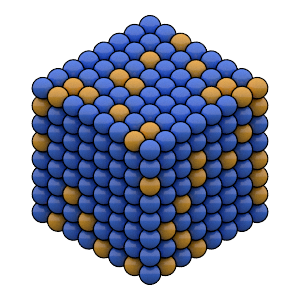

In [4]:
ex_render.render_sphere_frame(frame=sim.state.get_snapshot())

In [28]:
sim.create_state_from_gsd("test-system.gsd")

RuntimeError: Cannot initialize more than once


In [4]:
integrator = hoomd.md.Integrator(dt=0.0025)
tree = hoomd.md.nlist.Tree(0.3)
# lj = pair.KA_LJ_DPD(tree, 1.5)
lj = pair.KA_LJ(tree)

var = hoomd.variant.Ramp(1.5, 0.4, sim.timestep, sim.timestep + 1_000_000)
lang = hoomd.md.methods.Langevin(hoomd.filter.All(), var)
# lang = hoomd.md.methods.NVE(hoomd.filter.All())
integrator.forces = [lj]
integrator.methods = [lang]

sim.operations.integrator = integrator

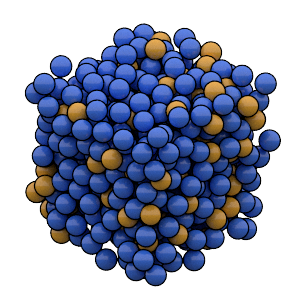

In [5]:
sim.run(10_000)
ex_render.render_sphere_frame(frame=sim.state.get_snapshot())

In [6]:
sim.run(1_100_000)
hoomd.write.GSD.write(sim.state, "equil-system-T0.4.gsd")

In [7]:
integrator = hoomd.md.Integrator(dt=0.0025)
tree = hoomd.md.nlist.Tree(0.3)
# lj = pair.KA_LJ_DPD(tree, 1.5)
lj = pair.KA_LJ(tree)

var = hoomd.variant.Ramp(0.4, 0.1, sim.timestep, sim.timestep + 1_000_000)
lang = hoomd.md.methods.Langevin(hoomd.filter.All(), var)
# lang = hoomd.md.methods.NVE(hoomd.filter.All())
integrator.forces = [lj]
integrator.methods = [lang]

sim.operations.integrator = integrator

In [8]:
sim.run(1_100_000)
hoomd.write.GSD.write(sim.state, "equil-system-T0.1.gsd")

In [6]:
lj.kT = 0.1

In [44]:
lang.kT = 0.6

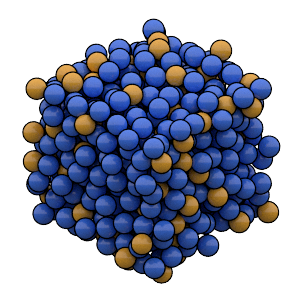

In [7]:
sim.run(10_000)
ex_render.render_sphere_frame(frame=sim.state.get_snapshot())

In [100]:
lang.kT = 0.01

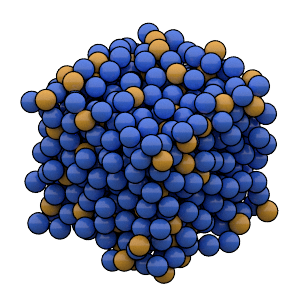

In [18]:
sim.run(100_000)
ex_render.render_sphere_frame(frame=sim.state.get_snapshot())

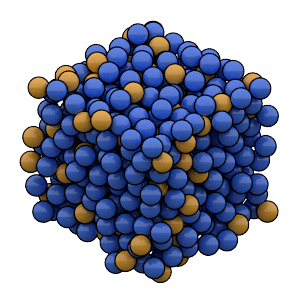

In [11]:
sim.run(10_000)
ex_render.render_sphere_frame(frame=sim.state.get_snapshot())

In [10]:
hoomd.write.GSD.write(sim.state, "test-system.gsd")

In [19]:
sim.operations.writers.clear()
basin_op = sim.sample_basin(100_000, 10)

(array([   7.,   52.,  112.,  204.,  349.,  556.,  746.,  896.,  938.,
         996., 1062.,  892.,  758.,  638.,  499.,  382.,  284.,  221.,
         152.,   82.,   74.,   51.,   33.,   13.,    3.]),
 array([0.00637606, 0.01539673, 0.0244174 , 0.03343806, 0.04245873,
        0.0514794 , 0.06050006, 0.06952073, 0.0785414 , 0.08756206,
        0.09658273, 0.1056034 , 0.11462406, 0.12364473, 0.1326654 ,
        0.14168606, 0.15070673, 0.1597274 , 0.16874806, 0.17776873,
        0.1867894 , 0.19581006, 0.20483073, 0.21385139, 0.22287206,
        0.23189273]),
 <BarContainer object of 25 artists>)

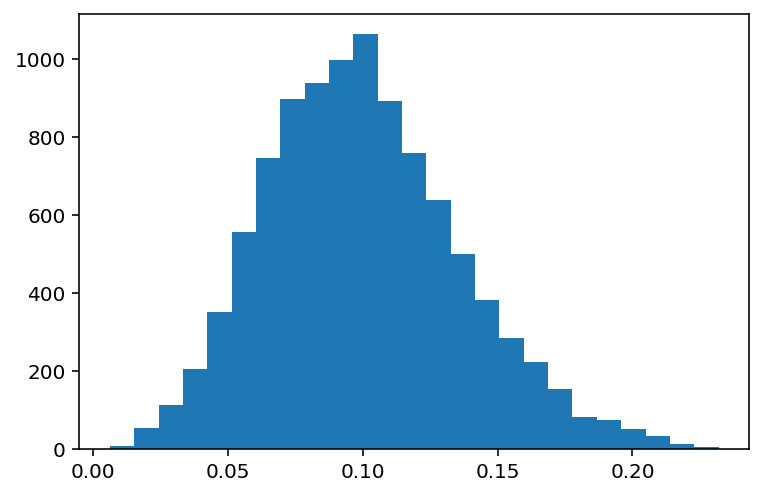

In [20]:
plt.hist(basin_op, bins=25)

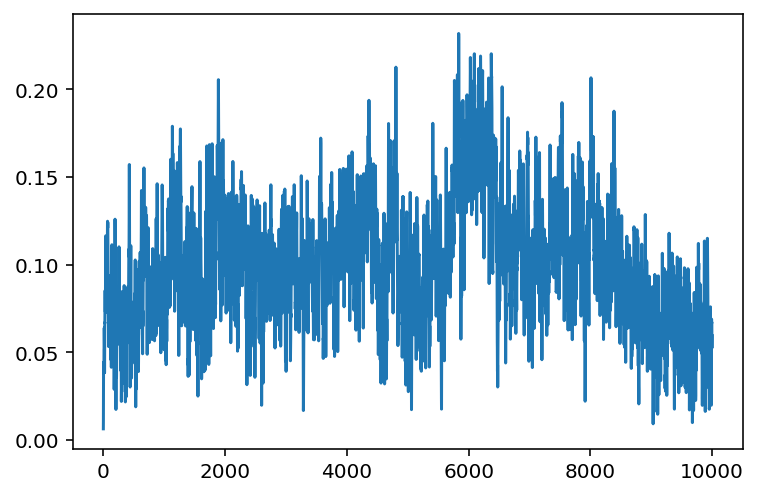

In [21]:
plt.plot(basin_op)

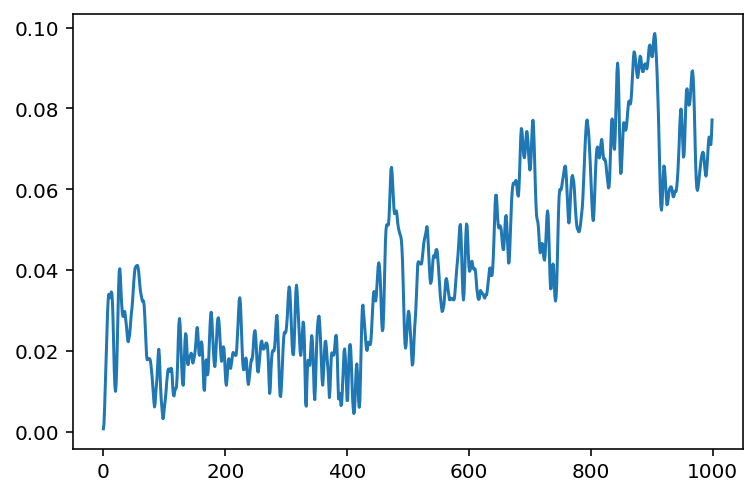

In [65]:
plt.plot(basin_op)

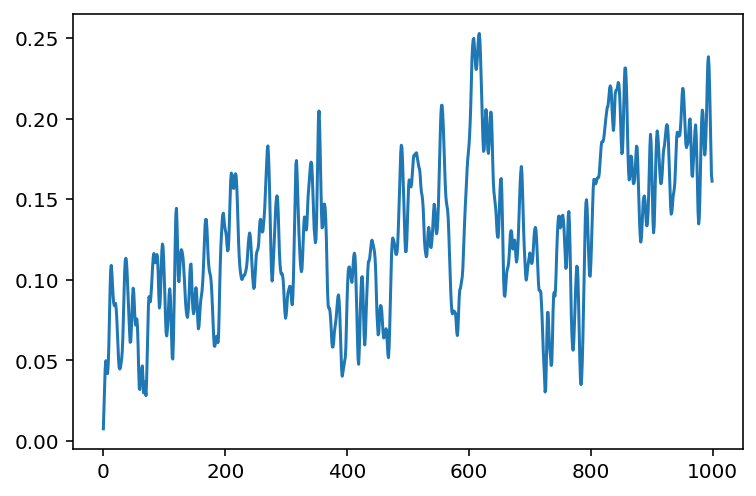

In [61]:
plt.plot(basin_op)

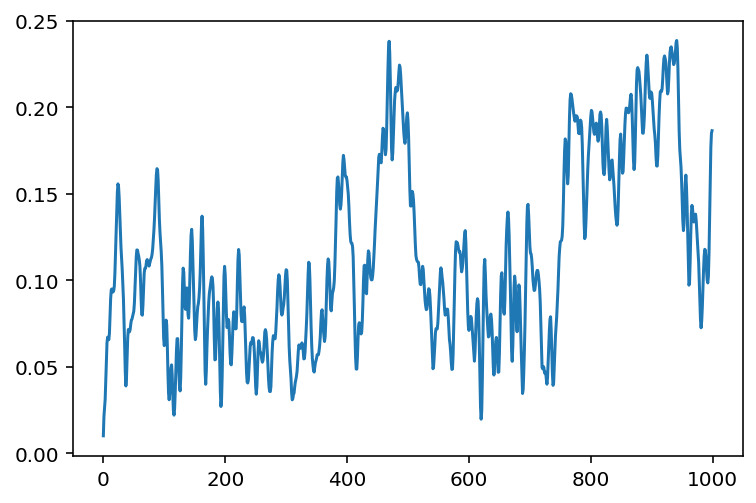

In [55]:
plt.plot(basin_op)

In [99]:
writer = hoomd.write.GSD(trigger=hoomd.trigger.Periodic(10), filename="test.gsd", mode="xb", filter=hoomd.filter.All())
sim.operations.writers.clear()
sim.operations.writers.append(writer)
sim.run(10_000)

In [94]:
sim.run(10_000, write_at_start=True)

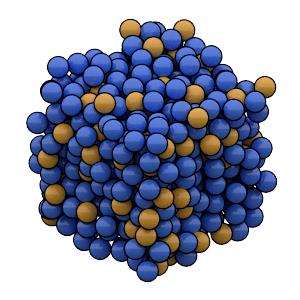

In [53]:
ex_render.render_sphere_frame(frame=sim.state.get_snapshot())

In [23]:
integrator, langevin, forces = sim._assert_langevin()

In [25]:

fire = hoomd.md.minimize.FIRE(**sim.fire_kwargs)
nve = hoomd.md.methods.NVE(hoomd.filter.All())
fire.methods = [nve]
fire.forces = [forces.pop() for _ in range(len(forces))]


In [26]:
len(fire.forces)

1

In [27]:
sim.operations.integrator = fire

In [29]:
fire.converged

False

In [30]:
sim.run(1000)

In [31]:
fire.converged

True